In [1]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
dview = rc[:]  # A DirectView of all engines
dview.block = True
rc.ids

[0, 1, 2, 3, 4]

In [2]:
%%px
import bluefog.torch as bf
from bluefog.common import topology_util
import networkx as nx

bf.init()
message = f"Hello, I am {bf.rank()} among {bf.size()} processes"
print(message)

[stdout:1] Hello, I am 2 among 5 processes


[stdout:3] Hello, I am 3 among 5 processes


[stdout:2] Hello, I am 4 among 5 processes


[stdout:0] Hello, I am 1 among 5 processes


[stderr:2] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:1] Invalid MIT-MAGIC-COOKIE-1 key

[stdout:4] Hello, I am 0 among 5 processes


[stderr:0] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:3] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:4] Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
# import os
# import sys
# import numpy as np

# from pymanopt.optimizers import ConjugateGradient

# sys.path.append('/home/yl-02/下载/experiments-main')

# from core.offline_problem import OfflineProblem
# from lib.function import pca
# from solver.offline_solver import OfflineSolver

# import config
# n=config.n
# T=config.T
# #block=config.block
# foldname = config.foldname
# St = config.mfd
# A = np.load( foldname + 'data_wave.npy' )
# X_0 = config.X_0

# list_T= list(np.arange(config.T))


# off_prob = OfflineProblem(  mfd = St,
#                             data = A,
#                             time = T,
#                             sum_loss = pca.sum_f,
#                             sum_grad = pca.sum_grad 
#                         ) 

# solver = OfflineSolver(solver = ConjugateGradient, mingrad = 1e-3)

# #X_0 = solver.optimize(off_prob,X_0,[T-1])
# X_opt = solver.optimize(off_prob,X_0,list_T)


# np.save( foldname +'data_offline',solver.offline_histories)
# #np.save( foldname + 'list_T',list_T)
# print('offline solver completed')
# opt = pca.func( A, X_opt)
# print(opt)

# dview.push({"X_opt": X_opt})
#dview.push({"opt": opt})

In [4]:
import os
import sys
import numpy as np
from sklearn.decomposition import PCA

import config
foldname = config.foldname

sys.path.append('/home/yl-02/下载/experiments-main')
from lib.function import pca

A = np.load( foldname + 'data_wave.npy' )

model = PCA(n_components = 5)
lower_dim_data = model.fit_transform(A)
print(f"降维后的特征维数：{model.n_components_}")

X_opt = model.components_.T
opt = pca.sum_f( A, X_opt)
print(opt)
print(X_opt)
dview.push({"X_opt": X_opt})
dview.push({"opt": opt})

np.save( foldname + 'X_0',X_opt)

/home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
降维后的特征维数：5
-7.213987992130418
[[ 5.22850811e-03  8.68955937e-03  9.12072796e-02  3.14774577e-02
  -4.57283558e-02]
 [-1.02329502e-01 -1.16221444e-01 -3.38740893e-02 -2.97397551e-02
   1.46318976e-02]
 [-1.79022468e-01 -1.85990219e-01  6.61254323e-02 -6.85167087e-03
   7.34222154e-02]
 [-2.26534147e-01 -2.12436065e-01  7.67633713e-03  1.18579106e-02
  -1.09979339e-02]
 [-2.54595045e-01 -2.29739117e-01 -1.99872613e-02  2.11518127e-02
   2.18831193e-02]
 [-2.83125085e-01 -1.54175697e-01 -1.20450176e-02  1.26212318e-02
  -3.28453235e-03]
 [-3.04900367e-01 -8.94931710e-02  1.43483692e-02  9.17303990e-03
   1.48787044e-02]
 [-2.96762596e-01  4.43704000e-02 -2.99346989e-03 -4.61320683e-04
  -2.19389998e-02]
 [-2.49267497e-01  2.36010021e-01 -1.17327713e-02 -1.13386002e-02
   5.82000753e-04]
 [-1.33859661e-01  3.92823673e-01 -2.06635024e-02  6.24511078e-03
   1.78400944e-02]
 [ 8.40409489e-03  4.66318068e-01 -6.37710285e-03  2.1

In [5]:
#数据分配
#import torch.utils.data.distributed


samples= A.shape[0]
num_nodes = len(rc.ids)
num_split = int(samples // num_nodes)
for i in range(num_nodes):
    data = A[i * num_split : (i + 1) * num_split]
    dview.push({"data": data}, targets=i)

In [6]:
%%px
import os
import sys

sys.path.append('/home/yl-02/下载/experiments-main')
import numpy as np
from core.online_problem import OnlineProblem
from lib.function import pca
from solver.stochastic_GTA import *

sys.path.append('/home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform')
import config


n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.RingGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver = StochasticGTA()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

[stdout:2] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:1] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:0] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:3] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:4] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


In [7]:
sys.path.append('/home/yl-02/下载/experiments-main')
from solver.stochastic_GTA import *

solver = StochasticGTA()
#value_SGTA = dview.pull("solver.op_histories", block=True, targets=0)
#grad_SGTA = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGTA = dview.pull("solver.oracle", block=True, targets=0)
hat_SGTA = dview.pull("solver.X_hat", block=True, targets=0)
grad_SGTA = list()
value_SGTA = list()
for i in range(len(hat_SGTA)):
    grad = pca.sum_grad(A, hat_SGTA[i])
    g_norm = np.linalg.norm(grad)
    loss = pca.sum_f(A, hat_SGTA[i])
    grad_SGTA.append(g_norm)
    value_SGTA.append(loss)

np.save( foldname + 'value_SGTA',value_SGTA)
np.save( foldname + 'grad_SGTA',grad_SGTA)
np.save( foldname+ 'oracle_SGTA',oracle_SGTA)

In [8]:
%%px
from solver.DR_SGD import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0

#graph
node = bf.size()    #number of nodes
G = topology_util.RingGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver =DR_SGD()
solver.optimize(ol_problem,X_0, X_opt)

print('gradient solver completed')

[stdout:0] gradient solver completed


[stdout:3] gradient solver completed


[stdout:2] gradient solver completed


[stdout:1] gradient solver completed


[stdout:4] gradient solver completed


In [9]:
from solver.DR_SGD import *

solver = DR_SGD()
# value_SGD= dview.pull("solver.op_histories", block=True, targets=0)
# grad_SGD = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGD = dview.pull("solver.oracle", block=True, targets=0)
hat_SGD = dview.pull("solver.X_hat", block=True, targets=0)
grad_SGD = list()
value_SGD = list()
for i in range(len(hat_SGTA)):
    grad = pca.sum_grad(A, hat_SGD[i])
    g_norm = np.linalg.norm(grad)
    loss = pca.sum_f(A, hat_SGD[i])
    grad_SGD.append(g_norm)
    value_SGD.append(loss)

np.save( foldname + 'value_SGD',value_SGD)
np.save( foldname + 'grad_SGD',grad_SGD)
np.save( foldname+ 'oracle_SGD',oracle_SGD)

In [10]:
%%px
from solver.cons_sample import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.RingGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver = ConsSample()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

[stdout:4] gradient solver completed


[stdout:0] gradient solver completed


[stdout:2] gradient solver completed


[stdout:3] gradient solver completed


[stdout:1] gradient solver completed


In [11]:
from solver.cons_sample import *

solver = ConsSample()
# value_cons = dview.pull("solver.op_histories", block=True, targets=0)
# grad_cons = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_cons = dview.pull("solver.oracle", block=True, targets=0)
hat_cons = dview.pull("solver.X_hat", block=True, targets=0)
grad_cons = list()
value_cons = list()
for i in range(len(hat_SGTA)):
    grad = pca.sum_grad(A, hat_cons[i])
    g_norm = np.linalg.norm(grad)
    loss = pca.sum_f(A, hat_cons[i])
    grad_cons.append(g_norm)
    value_cons.append(loss)

np.save( foldname + 'value_cons',value_cons)
np.save( foldname + 'grad_cons',grad_cons)
np.save( foldname+ 'oracle_cons',oracle_cons)

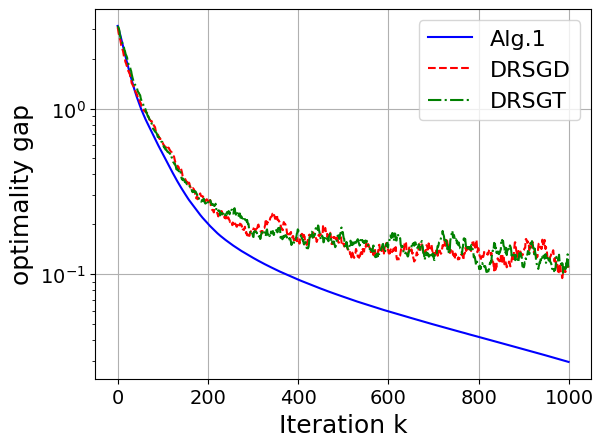

In [12]:
#plot
import sys
sys.path.append('.')

from lib.operation.calculate_gap import cal_gap
from lib.operation.figureplot import *
import matplotlib.pyplot as plt
import numpy as np
import config

foldname = config.foldname
res= load_data(foldname)
grid = list(np.arange(config.T))

cal_gap(res, opt)
plot_value (res,grid)
plt.show()

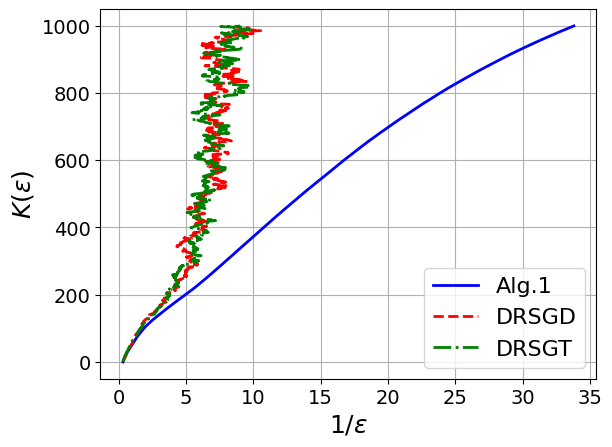

<Figure size 640x480 with 0 Axes>

In [13]:
for alg in res.values():
    axis_x = [x for x in alg['epsilon'] if x <= 40]
    length = len(axis_x)
    y = grid[:length]
    plt.plot(axis_x,y,linewidth=2,**alg["plot"])   

plt.legend(prop={'size':16})
plt.xlabel('$1/\epsilon$',fontdict={'size':18})
plt.ylabel('$K(\epsilon)$',fontdict={'size':18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.gcf().set_facecolor(np.ones(3))
plt.grid(True)
plt.show()

plt.savefig( 'ite_complex.png')

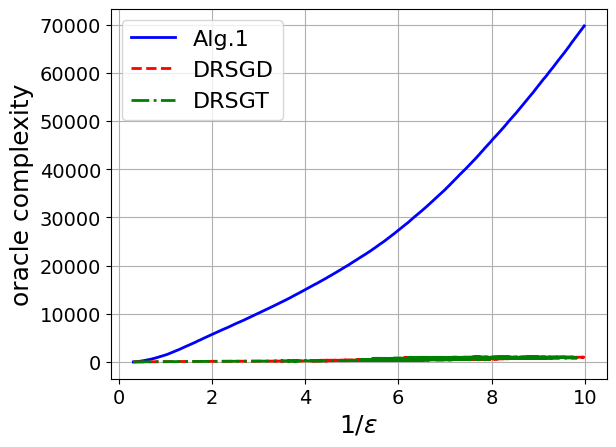

<Figure size 640x480 with 0 Axes>

In [14]:
for alg in res.values():
    axis_x = [x for x in alg['epsilon'] if x <= 10]
    length = len(axis_x)
    y = alg['oracle'][:length]
    plt.plot(axis_x,y,linewidth=2,**alg["plot"]) 

plt.legend(prop={'size':16})
plt.xlabel('$1/\epsilon$',fontdict={'size':18})
plt.ylabel('oracle complexity',fontdict={'size':18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.gcf().set_facecolor(np.ones(3))
plt.grid(True)
plt.show()

plt.savefig( 'orc_complex.png')

In [15]:
%%px
bf.suspend()

In [16]:
%%px
bf.resume()

In [17]:
loadData = np.load(foldname + 'value_VRSGT.npy')

In [18]:
print(loadData)

[-2.7067556  -2.76324738 -2.81702354 -2.87332433 -2.93570937 -2.95625533
 -3.13852917 -2.85102516 -3.54007218 -2.94014715 -3.24206331 -3.34306731
 -3.38133771 -3.482185   -3.48914595 -3.65054419 -3.60984969 -3.83799537
 -3.8782526  -4.06438906 -4.02232331 -4.10200124 -4.11534228 -4.2782929
 -4.16106472 -4.58638    -4.4030103  -4.72105284 -4.6644659  -4.93120977
 -4.86610015 -4.89674012 -4.92674906 -4.97635411 -4.96000456 -5.04926563
 -4.99357897 -5.07531557 -4.89567893 -4.99644881 -4.88079561 -4.93724935
 -4.96624562 -5.08016076 -5.01612414 -5.35620684 -5.1177434  -5.50377869
 -5.32810229 -5.42459209 -5.3809892  -5.42251545 -5.4504375  -5.47357461
 -5.50207258 -5.50093921 -5.55570081 -5.49420344 -5.59477393 -5.4036671
 -5.47189973 -5.52112922 -5.56835561 -5.57420852 -5.68900929 -5.59475923
 -5.85789237 -5.57402337 -6.02452703 -5.64297955 -6.0441589  -6.08041863
 -5.94313409 -6.15853422 -5.79779241 -6.40044172 -5.867792   -6.36569444
 -5.9155352  -6.26184207 -5.80099521 -5.83073504 -5.8